# Preprocessing dataset
- Set attribute names to pd.DataFrame;
- Replace `Class` values from `2 (benign)` and `4 (malignant)` to `0 (benign)` and `1 (malignant)`;
- Remove incomplete sample, sixteen samples has a missing attribute which contains character `?`.

In [216]:
import pandas as pd

DATASET_PATH = './data/breast-cancer-wisconsin.data'
COLUMN_NAMES = [
  'Sample code number',
  'Clump Thickness', # Espessura do Aglomerado
  'Uniformity of Cell Size', # Uniformidade do Tamanho da Célula
  'Uniformity of Cell Shape', # Uniformidade da Forma da Célula
  'Marginal Adhesion', # Adesão Marginal
  'Single Epithelial Cell Size', # Tamanho de célula epitelial única
  'Bare Nuclei', # Núcleos descobertos
  'Bland Chromatin', # Cromatina Insípida
  'Normal Nucleoli', # Nucléolos normais
  'Mitoses', # Mitoses
  'Class'
]

dataset = pd.read_csv(
  DATASET_PATH,
  header=None, # File with data has no header line.
  names=COLUMN_NAMES # Set column names.
)

# Remove Id column
dataset = dataset.drop('Sample code number', axis=1)

# Replace class values, from 2 (benign) and 4 (malignant) to 0 (benign) and 1 (malignant)
dataset.Class = dataset.Class.map({ 2: 0, 4: 1})

# Remove samples wich are missing at least one attribute.
incomplete_sample_indexes = []

for index, line in enumerate(dataset.values):
  if '?' in line:
    incomplete_sample_indexes.append(index)

print(len(incomplete_sample_indexes), 'incomplete samples found')

# remove lines based on received indexes
dataset = dataset.drop(incomplete_sample_indexes, axis=0)

dataset

16 incomplete samples found


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


# Split train and test groups
- Seet a SEED to keep results reproducible;
- Split 80% to train and 20% of the original dataset to test.

In [217]:
from sklearn.model_selection import train_test_split

# Set a seed to be able to replicate exact same result, remove it one the experiment is done.
SEED = 42

# Isolate labels
y = dataset.Class

# Isolate features.
X = dataset[
  [
    'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
    'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses'
  ]
]

# Split databases into train and test, set a 
train_X, test_X, train_y, test_y = train_test_split(
    X, 
    y,
    stratify=y,       # keep classes distribution on train and test
    shuffle=True,     # shuffle samples before split
    test_size=0.2,    # split 20% of the samples to test and 80% to train
    random_state=SEED # set a seed to make results reproducible
)

print('Train dataset', train_X.shape)
print('Test dataset', test_X.shape)

Train dataset (546, 9)
Test dataset (137, 9)


# Baseline
- Uses DummyClassifier with `most_frequent` classification strategy;
- Baseline `accuracy` is `65%`.

In [218]:
from sklearn.dummy import DummyClassifier

# Set a seed to be able to replicate exact same result, remove it one the experiment is done.
SEED = 42

classifier = DummyClassifier(strategy="most_frequent", random_state=SEED)

classifier.fit(train_X, train_y)

score = classifier.score(test_X, test_y)
print("DummyClassifier accuracy %i%%" % (round(score * 100)))

DummyClassifier accuracy 65%


# DecisionTreeClassifier
- Test `DecisionTreeClassifier` with `max_depth` of 3;
- Reaches a accuracy of `96%`, with split bases and classifier random state 42;
- Generates decision representation.

Decisiontree accuracy 96%


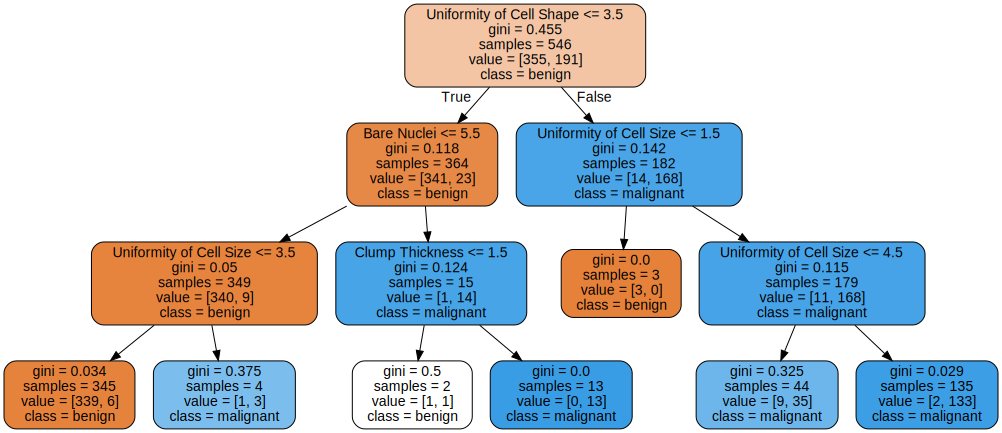

In [227]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# Set a seed to be able to replicate exact same result, remove it one the experiment is done.
SEED = 42

classifier = DecisionTreeClassifier(
  criterion="gini", 
  max_depth=3,
  random_state=SEED
)
classifier.fit(train_X, train_y)

score = classifier.score(test_X, test_y)
print("Decisiontree accuracy %i%%" % (round(score * 100)))

dot_data = export_graphviz(
  classifier,
  out_file=None, # path que o arquivo será salvo, None em notebooks
  filled=True, # colore as folhas de acordo com o grau de certeza
  rounded=True,
  feature_names=X.columns,
  class_names=["benign", "malignant"]
)

chart = graphviz.Source(dot_data)
chart

# Support Vector Machines
- Scale features using `StandardScaler`, when use features with its original values classifier `wasn't capable of converge`;
- Tests `LinearSVC` classifier with `default` params, this test does not aim optimization;
- Accuracy `96%`, with split bases and classifier random state 42.

In [224]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Set a seed to be able to replicate exact same result, remove it one the experiment is done.
SEED = 42

# Setup StandardScaler.
scaler = StandardScaler()
scaler.fit(X)

# Normalize feature values.
scalled_train_X = scaler.transform(train_X)
scalled_test_X = scaler.transform(test_X)

classifier = LinearSVC(random_state=SEED)

classifier.fit(scalled_train_X, train_y)
score = classifier.score(scalled_test_X, test_y)

print("LinearSVM accuracy %i%%" % (round(score * 100)))

LinearSVM accuracy 96%
